# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Toronto is the provincial capital of Ontario. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada and the fourth most populous city in North America. The city is the anchor of the Golden Horseshoe, an urban agglomeration of 9,245,438 people (as of 2016) surrounding the western end of Lake Ontario, while the Greater Toronto Area (GTA) proper had a 2016 population of 6,417,516. Toronto is an international center of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

#### Problem Definition:

A restaurant is a business which prepares and serves food and drink to customers in return for money, either paid before the meal, after the meal or with an open account. Toronto is a famous city. Its food culture includes an array of international cuisines influenced by the city’s immigrant history. So, it is evident that to survive in such competitive market it is very important to strategically plan.

## Data <a name="data"></a>

Various factors need to be studied in order to decide on location such as;

Toronto Population and demographics
Who are the competitors in that location?
Cuisine served / Menu of the competitors
Are there any Farmers Markets, Wholesale markets etc. nearby so that the ingredients can be purchased fresh to maintain quality and cost?
Are there any venues like Tourist attractions, Entertainment zones, Parks etc., nearby where floating population is high
Segmentation of the Borough
Untapped markets
Saturated markets etc. And the list goes on… Even though well-funded XYZ Company Ltd. needs to choose the correct location to start its first venture. If this is successful, they can replicate the same in other locations. First move is very important, thereby choice of location is very important.
To build a recommendation model, following datasets and information are considered for analysis;

Scrapped Wikipedia using Pandas, to extract information about 4 toronto boroughs also known as local authority districts. Also, considered local areas or neighborhoods for each borough for detailed analysis.
I used Foursquare API to get information about available restaurants for a given neighborhood and borough in Toronto. The API also provided information about restaurant styles based on cuisine.

### Importing libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Obtaining the data that is in the table of postal codes and to transform the data into a pandas dataframe

In [4]:
d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = d[0] #taking the firs data frame.
df2 = df[~df.Borough.str.contains("Not assigned")] #removing not assigned from the Borough coloumn
df2.Neighborhood = np.where(df2.Neighborhood == 'Not assigned', df2.Borough, df2.Neighborhood) #changing the neighborhood same as the borough in case of not assigned.

C:\Users\minar.munasib\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
df_csv = pd.read_csv('http://cocl.us/Geospatial_data') #reading the csv file of lattitude and longitude
df3 = pd.merge(df2, df_csv, on="Postal Code") #merging the lattitude and longitude with postal code dataframe

In [6]:
neighborhoods = df3[df3.Borough.str.contains('Toronto')].reset_index(drop=True) #taking only Boroughs in the dataframe which have Toronto in their name.

## Methodology <a name="methodology"></a>

In this project we will analyze the Boroughs of Toronto and its neighbourhoods. We will use Geopy to find the latitude and longitude of Toronto and will search nearby restaurants in 500km radius area. For this we will use Foursquare API. Then we will cluster it by using k-means clustering which is an unsupervised clustering model. Based on this we will conclude about the project.

#### Use geopy library to get the latitude and longitude values of Toronto.

In [7]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

### Creating foursquare API for explore

In [8]:
CLIENT_ID = 'IMGOXEIENUUL1EKAXRW3FRTKAUVCN0JCQ4Q4TSSFXGSA0RHO' # your Foursquare ID
CLIENT_SECRET = 'OXDA2UHG3G1IXKPTE0FO0SVDEA1N5JUTESIWFYWCPXWS4OIY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

### Explore Neighborhoods in Toronto

### creating a function to repeat the same process to all the neighborhoods in Manhattan

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Writing the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [10]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

### Checking the size of the resulting dataframe

In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(1614, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


### Checking how many venues were returned for each neighborhood

In [12]:
toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


### Extracting only restaurants from venue category list and creating a dataframe "Toronto restaurants"

In [13]:
toronto_restaurant = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]
print('There are {} unique categories or cusines available in Toronto.'.format(len(toronto_restaurant['Venue Category'].unique())))

There are 43 unique categories or cusines available in Toronto.


### Analyze Each Neighborhood & print each neighborhood along with the top 5 most common venues & putting the data in pandas dataframe

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_restaurant['Neighborhood'] 

# move neighborhood column to the first column

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 3

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

----Berczy Park----
                         venue  freq
0           Seafood Restaurant  0.17
1                   Restaurant  0.17
2  Eastern European Restaurant  0.08


----Brockton, Parkdale Village, Exhibition Place----
                venue  freq
0          Restaurant   0.5
1  Italian Restaurant   0.5
2   Afghan Restaurant   0.0


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Fast Food Restaurant   0.5
1            Restaurant   0.5
2     Afghan Restaurant   0.0


----Central Bay Street----
                 venue  freq
0   Italian Restaurant  0.22
1  Japanese Restaurant  0.17
2      Thai Restaurant  0.11


----Christie----
                venue  freq
0          Restaurant   0.5
1  Italian Restaurant   0.5
2   Afghan Restaurant   0.0


----Church and Wellesley----
                 venue  freq
0     Sushi Restaurant  0.22
1  Japanese Restaurant  0.17
2           Restaurant  0.13


----Commerce Court, Victo

### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Berczy Park,Seafood Restaurant,Restaurant,Thai Restaurant,Greek Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,French Restaurant,Eastern European Restaurant,Comfort Food Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,Central Bay Street,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Indian Restaurant,Modern European Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Middle Eastern Restaurant,French Restaurant
4,Christie,Italian Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


### Cluster Neighborhoods

### Running *k*-means to cluster the neighborhood into clusters.

In [16]:
# Creating new dataframe to determine best k value by dropping first column
toronto_clustering_testing = toronto_grouped.drop('Neighborhood', 1)

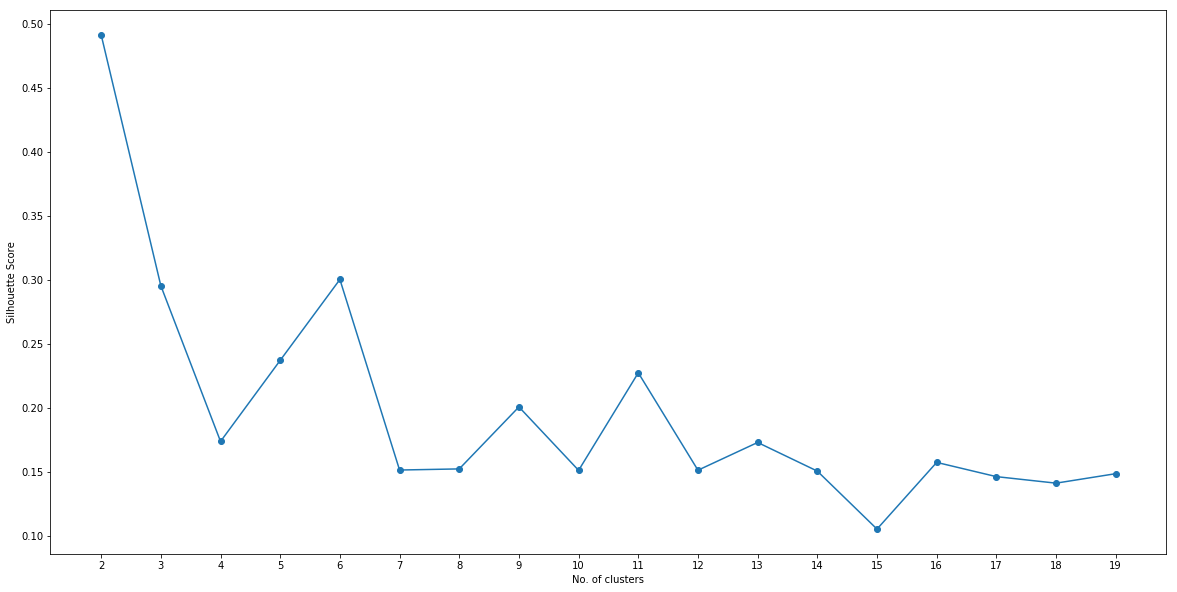

In [17]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = toronto_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [18]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

2

In [19]:
# set number of clusters
kclusters = opt

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating a new dataframe that includes the cluster as well as the top 10 Restaurent for each neighborhood.

In [20]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_restaurant

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
6,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
21,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
37,"Regent Park, Harbourfront",43.654260,-79.360636,Izumi,43.649970,-79.360153,Asian Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
45,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
47,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Sushi Box,43.662960,-79.386580,Sushi Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [21]:
toronto_merged['Cluster Labels'].value_counts()

0    379
1      1
Name: Cluster Labels, dtype: int64

### Finally, let's visualize the resulting clusters

In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Venue Latitude'], toronto_merged['Venue Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

### cluster 1

In [23]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
6,43.654260,-79.356980,Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
21,43.654260,-79.357843,French Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
37,43.654260,-79.360153,Asian Restaurant,0,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
45,43.662301,-79.387664,Italian Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
47,43.662301,-79.386580,Sushi Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
52,43.662301,-79.386977,Sushi Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
56,43.662301,-79.384796,Mexican Restaurant,0,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
84,43.657162,-79.381620,Thai Restaurant,0,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Modern European Restaurant,Ethiopian Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant
85,43.657162,-79.377586,Ramen Restaurant,0,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Modern European Restaurant,Ethiopian Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant
93,43.657162,-79.380910,Mexican Restaurant,0,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Modern European Restaurant,Ethiopian Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant


### cluster 2

In [24]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
259,43.676357,-79.298167,Asian Restaurant,1,Asian Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


# Result <a name="result"></a>

    Cluster	  1st common restaurant	       2nd common restaurant	    Least Common restaurant
        1	      Restaurant                American Restaurant	           French Restaurant
        2	    Asian Restaurant	        Vietnamese Restaurant	     Eastern European Restaurant


## Discussion <a name="discussion"></a>

* If XYZ company want to open a restaurant in preferred location and irrespective of cuisine, refer to that neighborhood in specific cluster and chose cuisine with the least common restaurant for better profits
* If XYZ company want to open a restaurant with a preferred cuisine and irrespective of location, refer to the cluster with the least number of restaurants with that specific cuisine and select one among the neighborhoods based on company’s preference.

## Conclusion <a name="conclusion"></a>

This analysis is performed on limited data. This may be right or may be wrong. But if good amount of data is available there is scope to come up with better results. If there are lot of restaurants probably there is lot of demand. Toronto has so many restaurants, yet certain neighborhood or borough doesn’t have a specific cuisine restaurant available. As per the neighborhood or restaurant type mentioned like Indian Restaurant analysis can be checked. A venue with lowest risk and competition can be identified.